In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xgboost/keras/default/1/best_model_xgboost_raw_plot.pkl
/kaggle/input/xgboost/keras/default/1/label_encoders_xgboost_raw_plot.pkl


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [131]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
import pytz

def preprocessTime(df, column):
    """Extracts additional time-based features from a datetime column."""
    df['hour '+ column] = df[column].dt.hour
    df['dayOfWeek '+ column] = df[column].dt.dayofweek
    df['month '+ column] = df[column].dt.month
    df['year '+column] = df[column].dt.year
    df['weekday ' + column] = (df[column].dt.dayofweek < 5).astype(int)
    df['time_of_day '+ column] = np.where((df['hour Created Date'] >= 6) & (df['hour Created Date'] < 18), 1, 0)
    return df


def removeOutliers(df, column, threshold=1.5):
    """Removes outliers using IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - threshold * IQR
    upperBound = Q3 + threshold * IQR
    outliers = df[(df[column] < lowerBound) | (df[column] > upperBound)]
    cleanDf = df[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    return cleanDf, outliers, lowerBound, upperBound


def addHolidays(df, column, tz=pytz.timezone('US/Pacific')):

    # Get US Holidays for given range
    cal = USFederalHolidayCalendar()
    Fed_holidays = cal.holidays('1-1-2010', '12-31-2027').date

    df['Fed Holiday'] = 0
    df[f'Holiday {column}'] = 0

    # Check if a holiday
    df['Fed Holiday'] = [x.date() in Fed_holidays for x in df[column]]

    # Combine both list of holidays
    df.loc[(df[f'Holiday {column}'] == True) | (df['Fed Holiday'] == True), f'Holiday {column}'] = 1

    # Delete temp columns
    del df['Fed Holiday']

    return df

def preprocessDataset(data):
    """
    Preprocesses the 311 service request dataset by cleaning, transforming, and engineering features.

    Steps performed:
    - Converts 'Created Date' and 'Closed Date' from string to datetime format.
    - Sorts the dataset by 'Created Date' and retains only the last 1/6th of the records.
    - Drops rows with missing values.
    - Computes the response time in hours.
    - Extracts time-related features from both 'Created Date' and 'Closed Date'.
    - Adds a holiday indicator feature based on 'Created Date'.
    - Transforms latitude and longitude into cyclic features (sin/cos).
    - Removes duplicate rows.
    - Filters out rows with negative response times.
    - Removes statistical outliers from the 'response_time' column.
    - Applies a log transformation to the response time and stores it in a new column 'logResponseTime'.

    Input:
        data: Dataframe containing 311 service request records.

    Returns:
        Cleaned and feature-engineered dataframe with 'logResponseTime' as the target variable.
    """

    df = data.copy()
    try: 
        
        # Convert string columns to datetime
        
        df['Created Date'] = pd.to_datetime(df['Created Date'].astype(str).str.strip(), errors='coerce')
                
        df = df.sort_values(by='Created Date')
        
        # Drop rows with missing values
        df = df.dropna()
        
        df['Closed Date'] = pd.to_datetime(df['Closed Date'].astype(str).str.strip(), errors='coerce')

               
        # Calculate response time in hours
        df['response_time'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds() / 3600
        
    
        # Preprocess time-related features
        df = preprocessTime(df, 'Created Date')
        
        df = preprocessTime(df, 'Closed Date')
        df = addHolidays(df, 'Created Date')
        
        df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
        df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
        # Convert latitude/longitude into cyclic features
        df['lat_sin'] = np.sin(np.radians(df['Latitude']))
        df['lat_cos'] = np.cos(np.radians(df['Latitude']))
        df['lon_sin'] = np.sin(np.radians(df['Longitude']))
        df['lon_cos'] = np.cos(np.radians(df['Longitude']))
    
        # Remove duplicates
        df.drop_duplicates(inplace=True)
    
        # Filter non-negative response times
        df = df[df['response_time'] >= 0]
        
        # Remove outliers
        cleanDf, _, _, _ = removeOutliers(df, 'response_time')
    
        # Apply log transformation
        cleanDf['logResponseTime'] = np.log1p(cleanDf['response_time'])
    except Exception as e:
        print(str(e))

    return cleanDf



In [124]:
# import requests
# import pandas as pd
# import time

# # API Endpoint
# base_url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# # Parameters
# batch_size = 1000  # API limit
# offset = 0
# all_data = []

# while True:
#     print(f"Fetching rows {offset} to {offset + batch_size}...")
    
#     # API request with pagination
#     params = {"$limit": batch_size, "$offset": offset}
#     response = requests.get(base_url, params=params)

#     if response.status_code != 200:
#         print(f"Error: {response.status_code}")
#         break  # Stop if there's an error
    
#     data = response.json()
    
#     if not data:  # Stop when no more data is returned
#         break
    
#     all_data.extend(data)
#     offset += batch_size  # Move to the next batch
#     time.sleep(1)  # Pause to avoid API rate limits

# # Convert to DataFrame
# df = pd.DataFrame(all_data)

# # Save to CSV in Kaggle
# csv_path = "/kaggle/working/nyc_311_requests.csv"
# df.to_csv(csv_path, index=False)

# print(f"Dataset saved to {csv_path}")

In [5]:
import joblib
bst = joblib.load('/kaggle/input/xgboost/keras/default/1/best_model_xgboost_raw_plot.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:31:42] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


{'lat_sin': 17.545997619628906, 'lat_cos': 18.47245979309082, 'lon_sin': 16.665847778320312, 'lon_cos': 20.78046989440918, 'time_of_day Created Date': 54.888458251953125, 'dayOfWeek Created Date': 97.69759368896484, 'month Created Date': 13.933402061462402, 'hour Created Date': 111.25865173339844, 'Holiday Created Date': 34.20876693725586, 'dayOfWeek Closed Date': 101.76342010498047, 'month Closed Date': 19.95940399169922, 'hour Closed Date': 111.32709503173828, 'Agency': 2329.849853515625, 'Complaint Type': 137.7957000732422, 'Street Name': 2.8136847019195557, 'City': 18.776931762695312, 'Borough': 81.863037109375, 'Open Data Channel Type': 89.50033569335938}


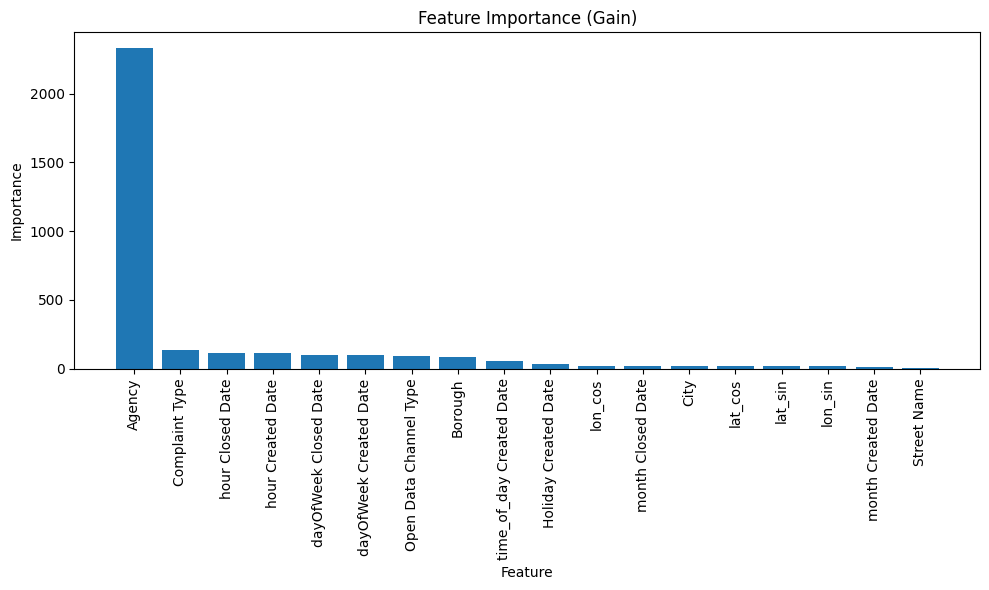

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot_feature_importance_old(bst, features, importance_type='gain'):  # Added importance_type
     """Plots feature importances from XGBoost model using bst.get_score()."""

     importance = bst.get_score(importance_type=importance_type) # specified importance type
     print(importance)
     feature_names = features

     feature_map={f'f{i}':feature_name for i, feature_name in enumerate(feature_names)}

     feature_importance = pd.DataFrame({'feature': [feature_map.get(f,f) for f in importance.keys()], 'importance':list(importance.values())})
     feature_importance = feature_importance.sort_values(by='importance', ascending=False)

     plt.figure(figsize=(10, 6))
     plt.bar(feature_importance['feature'], feature_importance['importance'])
     plt.xticks(rotation=90)
     plt.xlabel('Feature')
     plt.ylabel('Importance')
     plt.title(f'Feature Importance ({importance_type.capitalize()})') # Modified Title
     plt.tight_layout()
     plt.show()

numerical_cols = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos', 'time_of_day Created Date',
                  'dayOfWeek Created Date', 'month Created Date', 'weekday Created Date',
                  'hour Created Date', 'Holiday Created Date', 'time_of_day Closed Date', 'dayOfWeek Closed Date',
                  'month Closed Date', 'weekday Closed Date', 'hour Closed Date']

categorical_cols = ['Agency', 'Complaint Type', 'Street Name', 'City', 'Borough', 'Open Data Channel Type']
features = numerical_cols + categorical_cols


# Call the function after training your model:
plot_feature_importance_old(bst, features, importance_type='gain')

In [134]:
def predict_random_rows(data, model_path='/kaggle/input/xgboost/keras/default/1/best_model_xgboost_raw_plot.pkl', encoder_path='/kaggle/input/xgboost/keras/default/1/label_encoders_xgboost_raw_plot.pkl', num_samples=5):
    """
    Randomly selects rows from a DataFrame, predicts response times using a trained XGBoost model,
    and optionally compares predictions with actual response times.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        model_path (str): Path to the saved XGBoost model.
        encoder_path (str): Path to the saved label encoders.
        num_samples (int): The number of random rows to sample and predict.

    Returns:
        pd.DataFrame: A DataFrame containing the sampled rows, their predicted response times,
                      and (if available) their actual response times.
    """

    df = data.copy()

    # 1. Load the Model and Label Encoders
    bst = joblib.load(model_path)
    label_encoders = joblib.load(encoder_path)


    numerical_cols = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos', 'time_of_day Created Date',
                      'dayOfWeek Created Date', 'month Created Date', 'weekday Created Date',
                      'hour Created Date', 'Holiday Created Date', 'time_of_day Closed Date', 'dayOfWeek Closed Date',
                      'month Closed Date', 'weekday Closed Date', 'hour Closed Date']

    categorical_cols = ['Agency', 'Complaint Type', 'Street Name', 'City', 'Borough', 'Open Data Channel Type']
    features = numerical_cols + categorical_cols

    sampled_df = df.sample(n=num_samples,random_state=42)
    sampled_df = preprocessDataset(df)


    # 3. Prepare Data and Make Predictions
    predictions = []
    for index, row in sampled_df.iterrows():
        # Extract Features
        X_sample = row[features].copy()

        # Encode Categorical Features
        for col in categorical_cols:
            X_sample[col] = label_encoders[col].transform([X_sample[col]])[0] # Transform and get the single value


        # Convert to DataFrame (important for consistent handling by XGBoost)
        X_sample_df = pd.DataFrame([X_sample])


        # Create DMatrix
        d_sample = xgb.DMatrix(X_sample_df)

        # Make Prediction and Revert Log
        log_predicted_response_time = bst.predict(d_sample)[0]
        predicted_response_time = np.exp(log_predicted_response_time) # Revert the log transform

        predictions.append(predicted_response_time)



    # Add Predictions to the Sampled DataFrame
    sampled_df['predicted_response_time'] = predictions

    # try:
    #     sampled_df['actual_response_time'] = np.exp(sampled_df['logResponseTime'])
    #     mse = mean_squared_error(sampled_df['logResponseTime'], np.log(sampled_df['predicted_response_time']))
    #     rmse = np.sqrt(mse)
    #     r2 = r2_score(sampled_df['logResponseTime'], np.log(sampled_df['predicted_response_time']))
    #     print("Metrics on Sampled Data:  MSE:", mse, " RMSE:", rmse, " R2:", r2)
    # except KeyError:
    #     print("logResponseTime not found in sampled_df - cannot print metrics")


    try:
        # Get actual response times (un-log)
        sampled_df['actual_response_time'] = np.exp(sampled_df['logResponseTime'])

        # Metrics in original space
        mse = mean_squared_error(sampled_df['actual_response_time'], sampled_df['predicted_response_time'])
        rmse = np.sqrt(mse)
        r2 = r2_score(sampled_df['actual_response_time'], sampled_df['predicted_response_time'])

        print("Metrics on Sampled Data (original scale):")
        print(f"  MSE:  {mse:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R2:   {r2:.4f}")

    except KeyError:
        print("logResponseTime not found in sampled_df - cannot print metrics")

    return sampled_df[['actual_response_time','predicted_response_time']]

In [72]:
import requests

# API Endpoint
base_url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"
# Parameters
batch_size = 1000  # API limit
    
# API request with pagination
params = {"$limit": batch_size}
response = requests.get(base_url, params=params)

if response.status_code != 200:
    print(f"Error: {response.status_code}")

data = response.json()


# Convert to DataFrame
df = pd.DataFrame(data,index=None)

In [74]:
df.rename(columns={'created_date':'Created Date','agency':'Agency','complaint_type':'Complaint Type','city':'City','street_name':'Street Name','borough':'Borough','open_data_channel_type':'Open Data Channel Type','closed_date':'Closed Date','latitude':'Latitude','longitude':'Longitude'},inplace=True)
df.columns

Index(['unique_key', 'Created Date', 'Agency', 'agency_name', 'Complaint Type',
       'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'City', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'Borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'Open Data Channel Type',
       'park_facility_name', 'park_borough', 'Latitude', 'Longitude',
       'location', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_7mpf_4k6g', 'location_type', 'incident_address',
       'Street Name', 'cross_street_1', 'cross_street_2', 'landmark', 'bbl',
       'Closed Date', 'vehicle_type', 'taxi_pick_up_location',
       'taxi_company_borough', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge

In [105]:
# df[df['Created Date'].notna()].sample(n=10, random_state=42)
df = df[['Created Date', 'Closed Date','Agency','Borough','Complaint Type','City','Street Name',
                 'Open Data Channel Type','Latitude','Longitude']]

In [139]:
df

,Created Date,Closed Date,Agency,Borough,Complaint Type,City,Street Name,Open Data Channel Type,Latitude,Longitude
0,2025-04-09T02:07:53.000,NaN,DOT,MANHATTAN,Street Condition,MANHATTAN,NaN,UNKNOWN,40.764731973680775,-73.96635880834104
1,2025-04-09T01:51:07.000,NaN,NYPD,BROOKLYN,Noise - Residential,BROOKLYN,WEST 23 STREET,ONLINE,40.577619686746154,-73.99037761720334
2,2025-04-09T01:50:46.000,NaN,NYPD,BROOKLYN,Noise - Residential,BROOKLYN,BROOKLYN AVENUE,PHONE,40.67723419267206,-73.94423083418961
3,2025-04-09T01:50:29.000,NaN,DOHMH,BRONX,Rodent,BRONX,WOODYCREST AVENUE,PHONE,40.8315271048226,-73.92886303221528
4,2025-04-09T01:48:31.000,NaN,NYPD,QUEENS,Noise - Residential,FOREST HILLS,108 STREET,MOBILE,40.734724856034425,-73.85051397139026
...,...,...,...,...,...,...,...,...,...,...
995,2025-04-08T22:11:17.000,2025-04-08T23:55:18.000,NYPD,BRONX,Noise - Residential,BRONX,WEBSTER AVENUE,MOBILE,40.83764557949545,-73.90650442466341
996,2025-04-08T22:11:08.000,2025-04-09T01:35:58.000,NYPD,BROOKLYN,Noise - Residential,BROOKLYN,AUTUMN AVENUE,MOBILE,40.68319913043455,-73.87007059101576
997,2025-04-08T22:11:00.000,NaN,DOT,STATEN ISLAND,Street Light Condition,STATEN ISLAND,STOBE AVENUE,UNKNOWN,40.58509787993922,-74.10249185528649
998,2025-04-08T22:11:00.000,NaN,DEP,BRONX,Noise,BRONX,GRAND AVENUE,ONLINE,40.863481152365964,-73.9027732459544


In [135]:
randompredictions=predict_random_rows(df,num_samples=10)
randompredictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-131-4d2256ac6022>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanDf['logResponseTime'] = np.log1p(cleanDf['response_time'])


Metrics on Sampled Data (original scale):
  MSE:  0.13
  RMSE: 0.36
  R2:   0.8104


,actual_response_time,predicted_response_time
995,2.733611,1.718387
992,4.046389,3.750120
988,4.202222,3.894295
987,1.247500,1.395946
986,1.770833,1.388985
...,...,...
40,1.259167,1.339107
37,1.247778,1.348197
36,1.294722,1.384805
28,1.026667,1.207955


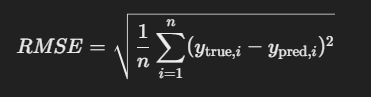

The predicted response time is, on average, off by ±0.36 hours or 21.6 minutes

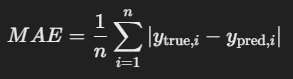

MAE does not penalize larger errors as much as RMSE does because it does not square the errors. Therefore, MAE gives a more direct interpretation of the average magnitude of error.
RMSE penalizes larger errors more heavily because of the squaring of the error terms, so it’s more sensitive to large deviations.
MAE is more robust to outliers because it treats all errors equally, without squaring them

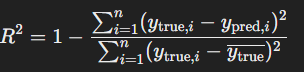

R-squared (R²), also called the coefficient of determination, explains how well the model’s predictions match the actual values. It represents the proportion of the variance in the actual response that is explained by the model.
The model was able to explain 81% of the variance in the actual response